# Inference of Sine Wave

In [1]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Make Dataset

In [2]:
timeline = np.arange(0, 60, 0.1)
y_np = (np.sin(timeline)).astype('f')
x_np = (y_np[:500] + (np.random.rand(len(timeline[:500])) * 0.2)).astype('f')  # add noise

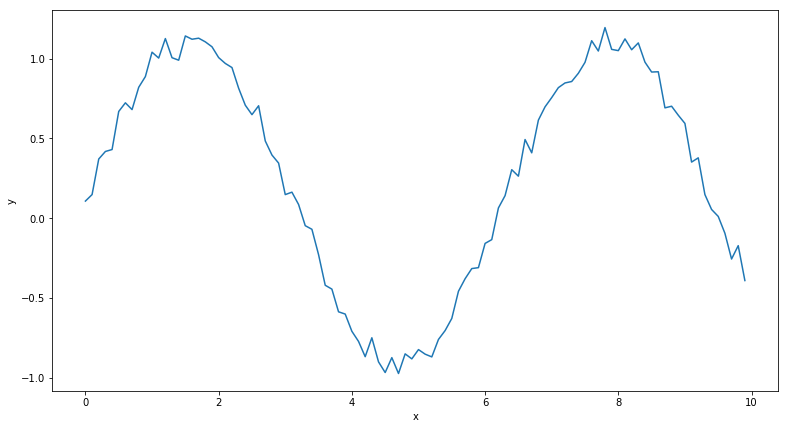

In [3]:
plt.figure(figsize=(13, 7))
plt.plot(timeline[0:100], x_np[0:100])

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
step_num = 100
pred_num = 1
X = []
y = []
for i in range(len(x_np) - step_num):
    X.append(x_np[i:i+step_num])
    y.append(y_np[i+step_num:i+step_num+pred_num])

### Example
index = 0  
X(input): timestep 0~99  
y(output): time 100

index = 1  
X(input): timestep 1~100  
y(output): time 101  

index = 2  
...  
index = 399  
X(input): timestep 400~499  
y(output): time 500

In [5]:
# Split DataSet and Make Batch
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Training

In [6]:
class Model_lstm(nn.Module):
    def __init__(self, length_of_sequence):
        super(Model_lstm, self).__init__()
        input_size = 1
        hidden_size = 10
        in_features = 1000
        out_features = 1
        layer1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.layers = nn.ModuleList([layer1])
        fc1 = nn.Linear(in_features=in_features, out_features=out_features)
        self.functions = nn.ModuleList([fc1])
        
    def forward(self,x):
        x, c = self.layers[0](x) 
        x = F.relu(x)

        T, N, D = x.size()
        x = x.view(1, T*N*D)
        x = self.functions[0](x)
        
        return x

In [7]:
model_lstm = Model_lstm(step_num)

criterion = nn.MSELoss()

optimizer = optim.SGD(model_lstm.parameters(), lr=0.001, momentum=0.9)

In [8]:
epochs = 30

for epoch in range(epochs):

    running_loss = 0.0  # total loss in 1-epoch 

    for i in range(len(X_train)):
        inputs = torch.from_numpy(X_train[i]).view(100, 1, 1)
        label = torch.from_numpy(y_train[i])
        inputs, label = Variable(inputs, requires_grad=True), Variable(label)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs.view(1, 1), label.view(1, 1))
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
    print('[{0:3},'.format(epoch + 1) + '{0:3d}]'.format(epochs) + 'loss: %.5f' % (running_loss))
    running_loss = 0.0

print('Finished Training')

[  1, 30]loss: 21.45303
[  2, 30]loss: 0.01022
[  3, 30]loss: 0.00938
[  4, 30]loss: 0.00904
[  5, 30]loss: 0.00884
[  6, 30]loss: 0.00868
[  7, 30]loss: 0.00855
[  8, 30]loss: 0.00843
[  9, 30]loss: 0.00832
[ 10, 30]loss: 0.00821
[ 11, 30]loss: 0.00812
[ 12, 30]loss: 0.00802
[ 13, 30]loss: 0.00794
[ 14, 30]loss: 0.00786
[ 15, 30]loss: 0.00778
[ 16, 30]loss: 0.00771
[ 17, 30]loss: 0.00764
[ 18, 30]loss: 0.00757
[ 19, 30]loss: 0.00751
[ 20, 30]loss: 0.00746
[ 21, 30]loss: 0.00740
[ 22, 30]loss: 0.00735
[ 23, 30]loss: 0.00731
[ 24, 30]loss: 0.00726
[ 25, 30]loss: 0.00722
[ 26, 30]loss: 0.00718
[ 27, 30]loss: 0.00715
[ 28, 30]loss: 0.00711
[ 29, 30]loss: 0.00708
[ 30, 30]loss: 0.00704
Finished Training


In [9]:
PATH = "model_sin.pth"
#torch.save(model_lstm.state_dict(), PATH)  # save model

## Inference

In [10]:
model_inf = Model_lstm(step_num)
model_inf.load_state_dict(torch.load(PATH))  # load model
model_inf.eval()

Model_lstm(
  (layers): ModuleList(
    (0): LSTM(1, 10)
  )
  (functions): ModuleList(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)

In [11]:
pred_size = len(y_np[500:600])
pred = x_np[400:500].tolist()
for i in range(pred_size):
    inputs_pred = torch.tensor(pred).view(100, 1, 1)
    output_pred = model_inf(inputs_pred)
    pred.pop(0)
    pred.append(output_pred.view(1).detach().tolist()[0])

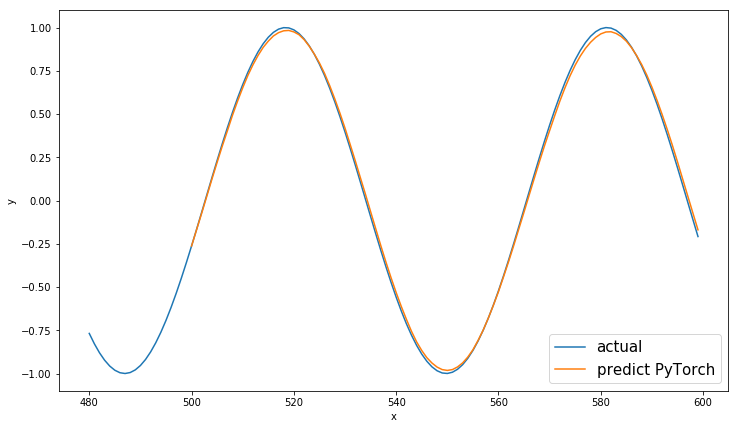

In [12]:
timeline_pred = np.arange(500, 600, 1)
timeline_act = np.arange(480, 600, 1)

plt.figure(figsize=(12, 7))
plt.plot(timeline_act, y_np[480:], label="actual")
plt.plot(timeline_pred, pred, label="predict PyTorch")
plt.legend(loc="lower right", fontsize="15")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Set param in C(Copy & Paste)

In [13]:
# lstm_weight_x size
model_lstm.layers[0].weight_ih_l0.detach().size()

torch.Size([40, 1])

In [14]:
# lstm_weight_h size
model_lstm.layers[0].weight_hh_l0.detach().size()

torch.Size([40, 10])

In [15]:
# lstm_bias size
model_lstm.layers[0].bias_hh_l0.detach().size()

torch.Size([40])

In [16]:
# lr_weight size
model_lstm.functions[0].weight.detach().size()

torch.Size([1, 1000])

In [17]:
# lr_bias size
model_lstm.functions[0].bias.detach().size()

torch.Size([1])

In [18]:
def param_to_str1d(param):
    param_1d = param.detach().numpy().T.flatten()
    param_1d_str_list = ["%.9f" % i for i in param_1d]
    return param_1d_str_list

# input Modlelist  return param's list of str
def to_params_str1d(modle_list):
    model_params_str1d = []
    for i in range(len(modle_list)):
        model_param_str1d = [param_to_str1d(param) for param in modle_list[i].parameters()]
        model_params_str1d.append(model_param_str1d)
    return model_params_str1d 

In [19]:
layer1_params = to_params_str1d(model_lstm.layers)[0]

In [20]:
layer1_weight_x = layer1_params[0]
layer1_weight_h = layer1_params[1]
layer1_bias = param_to_str1d(model_lstm.layers[0].bias_ih_l0 + model_lstm.layers[0].bias_hh_l0)

In [21]:
arr_begin = "{"
arr_end = "};"

# lstm_weight_x param
arr_begin + ", ".join(layer1_weight_x) + arr_end

'{-0.267434686, -0.127996340, -0.241046041, -0.304750502, -0.194549084, 0.315034688, 0.088713162, -0.001450234, -0.042000733, -0.121265516, 0.057373334, -0.254123509, -0.185460508, -0.106198296, 0.021087622, -0.105713859, 0.062167171, 0.194945008, -0.030992804, -0.116442494, 0.153765082, -0.252396017, 0.048587505, 0.014659001, -0.331173092, -0.224409118, 0.313103408, -0.216801479, 0.132903472, -0.005588919, 0.124093384, 0.137117714, -0.069392063, 0.161970407, -0.056925345, -0.266830862, 0.070033193, 0.093848571, -0.038115658, -0.294540197};'

In [22]:
# lstm_weight_h param
arr_begin + ", ".join(layer1_weight_h) + arr_end

'{0.211038411, 0.280405730, -0.203906924, 0.034226015, 0.278591067, 0.175626725, 0.044701003, -0.135196686, -0.178362593, 0.124883011, -0.011475857, -0.212792784, -0.026427345, 0.035919029, 0.107172139, -0.032518696, 0.175375715, -0.039864797, -0.298714101, -0.066668831, -0.188388914, -0.108064316, 0.276009411, -0.022342592, -0.068333782, 0.264026999, -0.102137528, 0.075543240, -0.200821653, 0.227811337, 0.292135805, 0.057587460, 0.143504813, 0.248188227, 0.309723526, -0.096351638, -0.085147634, 0.292301565, -0.129061684, 0.233616620, -0.183634549, -0.165571451, -0.087686494, 0.267275900, 0.279626697, 0.086797364, 0.198268637, -0.192340851, 0.040092304, -0.103850506, 0.006710365, 0.247303441, 0.000089363, 0.102261707, -0.188705191, 0.025348691, 0.295058042, 0.032225389, -0.152858466, 0.011534153, -0.075453602, -0.248286411, -0.238742456, -0.263271332, -0.227839708, -0.102051310, 0.006074955, -0.068488128, -0.064341240, 0.065481447, -0.034188177, 0.015996199, -0.261656940, -0.259035528,

In [23]:
# lstm_bias_h param
arr_begin + ", ".join(layer1_bias) + arr_end

'{0.018373914, -0.188251495, -0.093983769, 0.284707189, -0.026213706, -0.052586392, -0.026233401, -0.171442181, 0.308903724, -0.241244763, -0.307901591, 0.028180873, -0.130986497, -0.103981584, 0.382181883, -0.080892697, 0.592484117, -0.011579156, 0.340821207, -0.185834855, 0.030147776, 0.240937829, 0.017911062, -0.257830322, 0.403752029, -0.188521475, 0.086662382, 0.179271907, -0.049792610, 0.027134761, -0.118092954, 0.151759714, -0.308791071, 0.270513147, -0.534492850, -0.150067538, -0.067245983, 0.016669691, 0.119957127, 0.263606668};'

In [24]:
func1_params = to_params_str1d(model_lstm.functions)[0]
func1_weight = func1_params[0]
func1_bias = func1_params[1]

In [25]:
# lr_weight param
arr_begin + ", ".join(func1_weight) + arr_end

'{0.023175387, -0.010640677, 0.027040303, -0.031479072, -0.004034408, -0.019894345, -0.025777323, -0.009382024, 0.001001947, -0.012887339, -0.030708954, 0.026875231, -0.028657639, -0.030413857, 0.013335195, -0.004882035, -0.030729946, 0.012973304, -0.028519874, -0.020779941, -0.022400776, 0.006233235, -0.030253299, -0.009904925, 0.061607383, -0.028249791, -0.007743140, 0.026761604, -0.000473322, -0.019542633, -0.015896495, 0.022574583, 0.002812343, -0.009902131, 0.029768057, 0.022395544, -0.003831584, 0.008349626, 0.009448366, -0.022286614, 0.011076248, 0.018625516, -0.023871221, -0.002887880, 0.021331798, 0.029348630, -0.048011586, 0.003367944, -0.026445869, 0.028522305, 0.012941703, 0.007471371, 0.015695345, 0.009257905, 0.023801258, 0.009508438, -0.008040949, 0.048669484, -0.022006521, 0.023007644, -0.016536251, 0.028270982, -0.020226685, 0.015091393, 0.073300019, 0.004047520, -0.060271166, 0.000576108, 0.008037084, -0.012215508, -0.014289474, 0.008718158, 0.012724902, 0.005160846, 

In [26]:
# lr_bias param
arr_begin + ", ".join(func1_bias) + arr_end

'{-0.019736966};'

In [27]:
# input_x param
arr_begin + ", ".join(x_np[400:500].astype(str).tolist()) + arr_end

'{0.7870594, 0.7957617, 0.69823444, 0.6508203, 0.5495051, 0.37597457, 0.2473222, 0.14875819, 0.15665999, -0.049335577, -0.023821928, -0.2065435, -0.3015138, -0.24987994, -0.48387522, -0.4429239, -0.6106722, -0.7352999, -0.6758182, -0.70198554, -0.794438, -0.92499727, -0.86822194, -0.82850766, -0.84487504, -0.8004133, -0.82008266, -0.874295, -0.7625296, -0.7309362, -0.80724245, -0.6204992, -0.6466767, -0.50536186, -0.49051213, -0.28973925, -0.3380574, -0.15829031, -0.1285131, 0.08477531, 0.079749994, 0.15865853, 0.22560933, 0.33355227, 0.57752043, 0.5691949, 0.7467413, 0.78798854, 0.8339698, 0.8101296, 0.9045058, 1.0614643, 1.1286478, 1.0750327, 1.0043513, 1.0623417, 1.0357231, 1.0906588, 0.9766535, 1.1331674, 1.0314078, 1.0410806, 0.88586533, 0.88394105, 0.8257387, 0.713848, 0.6546121, 0.46228725, 0.4757981, 0.24064244, 0.13714507, 0.15083003, 0.019658681, -0.04659406, -0.19328356, -0.3518054, -0.278961, -0.45410073, -0.5077377, -0.5695204, -0.69932026, -0.6731035, -0.71165985, -0.9124

## Get stdout of C

In [28]:
import subprocess
import os
pred_stdout_c_lang = subprocess.Popen('../sample/lstm', stdout=subprocess.PIPE).communicate()[0]
pred_c_lang = [float(i.replace("b'", "").replace("'", "")) for i in str(pred_stdout_c_lang[:-1]).split("\\n")]

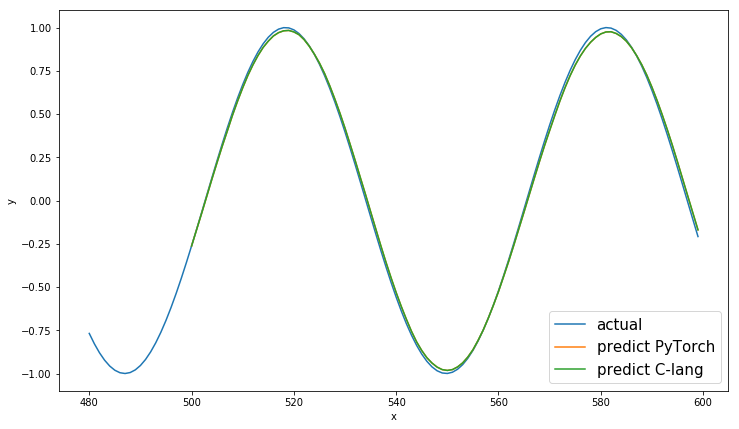

In [29]:
timeline_pred = np.arange(500, 600, 1)
timeline_act = np.arange(480, 600, 1)

plt.figure(figsize=(12, 7))
plt.plot(timeline_act, y_np[480:], label="actual")
plt.plot(timeline_pred, pred, label="predict PyTorch")
plt.plot(timeline_pred, pred_c_lang, label="predict C-lang")
plt.legend(loc="lower right", fontsize="15")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Disadvantage
Sorry, we have not been able to set parameters of this model automatically yet.